In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [51]:
data = pd.read_csv('cleaned_data_crime_rate.csv')

In [52]:
data.head()

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,inter1,inter2,...,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,Month,Day
0,NIG38575,2024-09-20,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (Nigeria),6,0,...,11.8826,13.0890,1,Whatsapp,New media,"On 20 September 2024, IDPs (flood victims) fro...",0,1727134598,9,20
1,NIG38585,2024-09-20,2024,2,Demonstrations,Protests,Peaceful protest,Protesters (Nigeria),6,0,...,7.4824,4.5603,1,Daily Trust (Nigeria),National,"Around 20 September 2024 (as reported), hundre...",0,1727134598,9,20
2,NIG38581,2024-09-19,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (Nigeria),6,0,...,7.4035,3.9132,1,Daily Post (Nigeria); Guardian (Nigeria); Saha...,National-Regional,"On 19 September 2024, for a second consecutive...",0,1727134598,9,19
3,NIG38588,2024-09-19,2024,1,Strategic developments,Strategic developments,Disrupted weapons use,Police Forces of Nigeria (2023-),1,4,...,10.6179,7.2331,1,Daily Post (Nigeria); Nigeria Punch,National,"Weapons seizure: On 19 September 2024, Police ...",0,1727134598,9,19
4,NIG38591,2024-09-19,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (Nigeria),6,0,...,7.1389,6.5724,1,Vanguard (Nigeria),National,"On 19 September 2024, PDP youths protested at ...",0,1727134598,9,19


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38075 entries, 0 to 38074
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event_id_cnty   38075 non-null  object 
 1   event_date      38075 non-null  object 
 2   year            38075 non-null  int64  
 3   time_precision  38075 non-null  int64  
 4   disorder_type   38075 non-null  object 
 5   event_type      38075 non-null  object 
 6   sub_event_type  38075 non-null  object 
 7   actor1          38075 non-null  object 
 8   inter1          38075 non-null  int64  
 9   inter2          38075 non-null  int64  
 10  interaction     38075 non-null  int64  
 11  iso             38075 non-null  int64  
 12  region          38075 non-null  object 
 13  country         38075 non-null  object 
 14  admin1          38075 non-null  object 
 15  admin2          38075 non-null  object 
 16  location        38075 non-null  object 
 17  latitude        38075 non-null 

In [54]:
data.columns

Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1', 'inter1',
       'inter2', 'interaction', 'iso', 'region', 'country', 'admin1', 'admin2',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp', 'Month', 'Day'],
      dtype='object')

In [55]:
numeric_data = data.select_dtypes(include=[float, int])

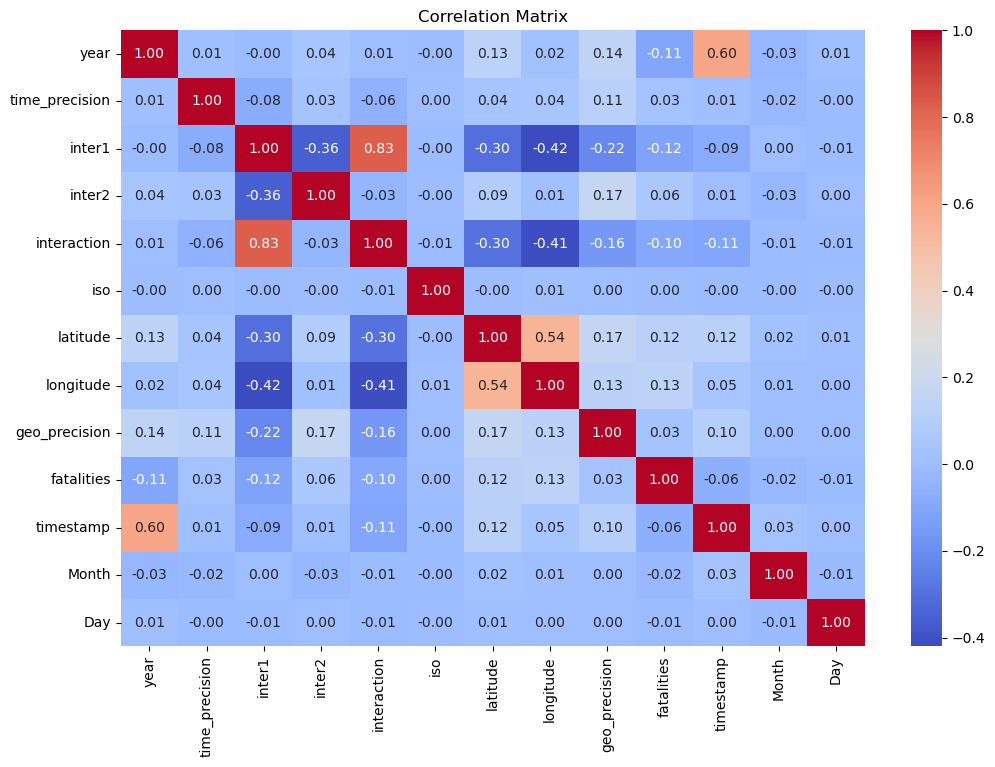

In [56]:
#Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Plotting the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [57]:
# Drop any obviously irrelevant columns
irrelevant_columns = ['event_id_cnty', 'timestamp','iso','country','region','event_date']  # replace with actual column names if any
data = data.drop(columns=irrelevant_columns, errors='ignore')

In [58]:
data.columns

Index(['year', 'time_precision', 'disorder_type', 'event_type',
       'sub_event_type', 'actor1', 'inter1', 'inter2', 'interaction', 'admin1',
       'admin2', 'location', 'latitude', 'longitude', 'geo_precision',
       'source', 'source_scale', 'notes', 'fatalities', 'Month', 'Day'],
      dtype='object')

In [59]:
# Identify categorical features for encoding
categorical_features = ['disorder_type','event_type','sub_event_type']
high_cardinality_features = ['actor1', 'admin1', 'admin2','location','source','source_scale','notes']  

# One-hot encode low-cardinality features
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Label encode high-cardinality features
label_encoder = LabelEncoder()
for feature in high_cardinality_features:
    data[feature] = label_encoder.fit_transform(data[feature].astype(str))

In [60]:
X = data.drop(columns=['fatalities'])
y = data['fatalities']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Linear Regression - MAE: 4.10, RMSE: 15.56
Decision Tree - MAE: 3.74, RMSE: 18.34
Random Forest - MAE: 3.18, RMSE: 14.43


THE RANDOM FOREST REGRESSSOR PRODUCED THE BEST RESULT